In [41]:
#!pip install graph-tiger --user

from graph_tiger.measures import get_measures, run_measure

In [42]:
get_measures()

['node_connectivity',
 'edge_connectivity',
 'diameter',
 'average_distance',
 'average_inverse_distance',
 'average_vertex_betweenness',
 'average_edge_betweenness',
 'average_clustering_coefficient',
 'largest_connected_component',
 'spectral_radius',
 'spectral_gap',
 'natural_connectivity',
 'spectral_scaling',
 'generalized_robustness_index',
 'algebraic_connectivity',
 'number_spanning_trees',
 'effective_resistance']

In [43]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

import community as community_louvain

In [44]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [45]:
data = r'data/network_analysis_edgelist.csv'

df = pd.read_csv(data)
df.head()

,source,target
0,Network science,Network science
1,Network science,Hub (network science)
2,Network science,Network theory
3,Network science,National Science Foundation Network
4,Network science,Efficiency (network science)


In [46]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

In [47]:
print(nx.info(G))

Graph with 51268 nodes and 76211 edges


# Network Brittleness / Robustness

Write about it

# PageRank - Identify Nodes of Interest

In [48]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Glossary of graph theory,0.000341
List of statistics articles,0.000238
Internet,0.000206
Lists of mathematics topics,0.000188
Artificial intelligence,0.000187
Computer network,0.000185
Graph theory,0.000185
Machine learning,0.000180
List of unsolved problems in mathematics,0.000178
List of graph theory topics,0.000171


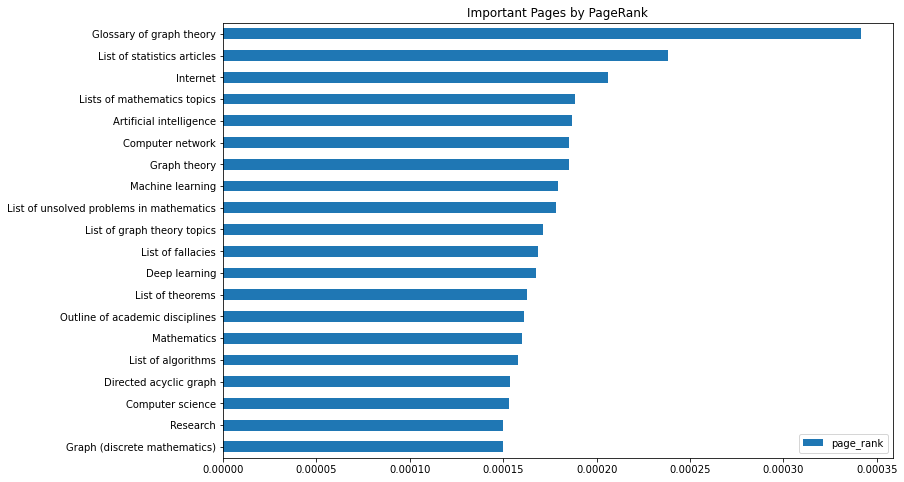

In [49]:
title = 'Important Pages by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [50]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [51]:
# identify communities; set resolution to 0.01 for smaller groups and 1 for larger groups, etc
# play with the number to get communities to the size you want them, or leave it at the default

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) 

In [52]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities
community_df = community_df[community_df['node'].str.contains('network|graph|science|inference')]

community_df['community'].value_counts()[0:20]

404     26
373     24
46      19
89      18
392     16
278     16
536     14
1112    13
54      12
1869    12
1084    12
501     12
1549    11
5       11
82      11
447     11
75      11
1298    10
753     10
2058    10
Name: community, dtype: int64

In [53]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([ 404,  373,   46,   89,  392,  278,  536, 1112,   54, 1869, 1084,
        501, 1549,    5,   82,  447,   75, 1298,  753, 2058], dtype=int64)

## Exploring Communities
Below, I am showing the largest community in the network. Looking at some of the node labels, I can see many instances of the word "graph". We are in the right place. 

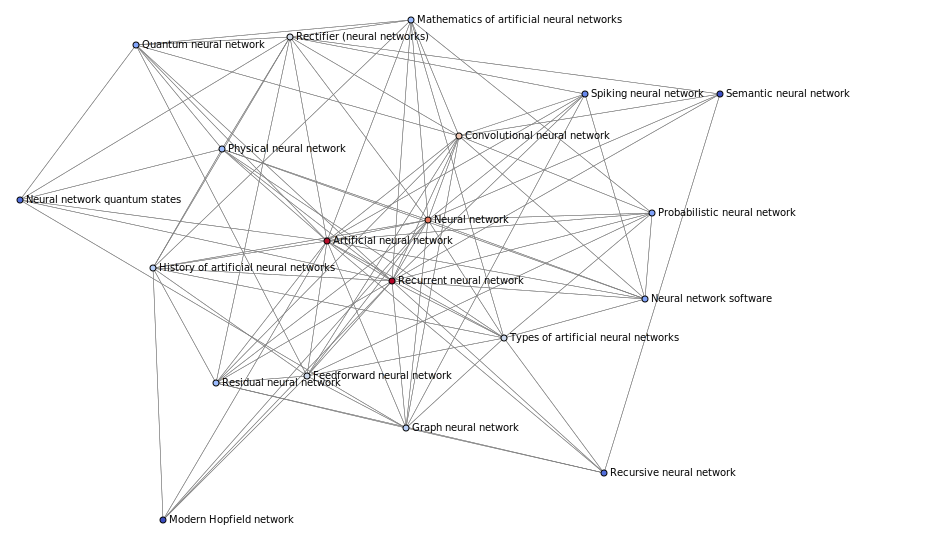

In [54]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 5), show_names=True, node_size=3)

In [55]:
radius = run_measure(G_comm, measure='spectral_radius')
radius

11.37

## More Communities!

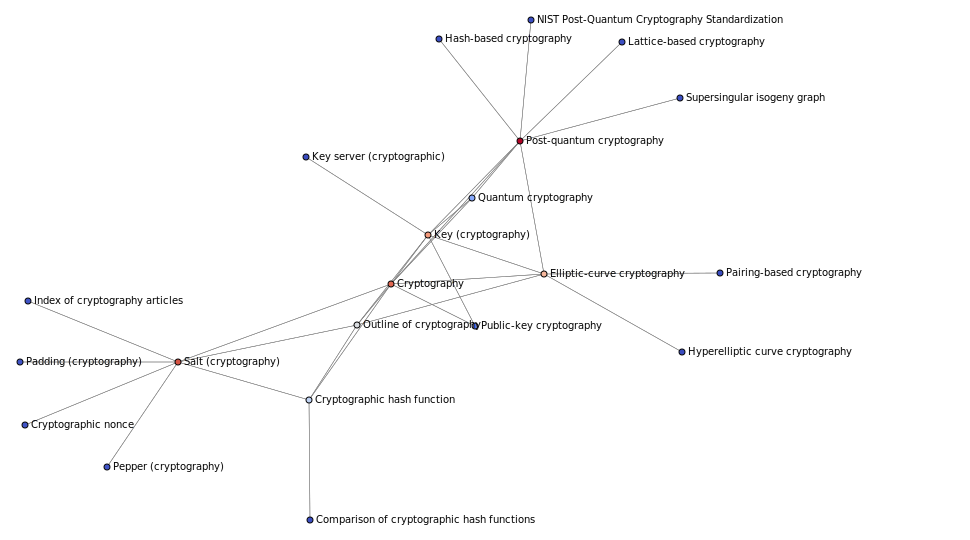

In [18]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [19]:
[print(n) for n in sorted(G_comm.nodes)]

Comparison of cryptographic hash functions
Cryptographic hash function
Cryptographic key types
Cryptographic nonce
Cryptography
Elliptic-curve cryptography
Hash-based cryptography
Homomorphic signatures for network coding
Hyperelliptic curve cryptography
Index of cryptography articles
Key (cryptography)
Key server (cryptographic)
Lattice-based cryptography
List of cryptographers
NIST Post-Quantum Cryptography Standardization
Outline of cryptography
Padding (cryptography)
Pairing-based cryptography
Pepper (cryptography)
Post-quantum cryptography
Public-key cryptography
Quantum cryptography
Salt (cryptography)
Supersingular isogeny graph


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

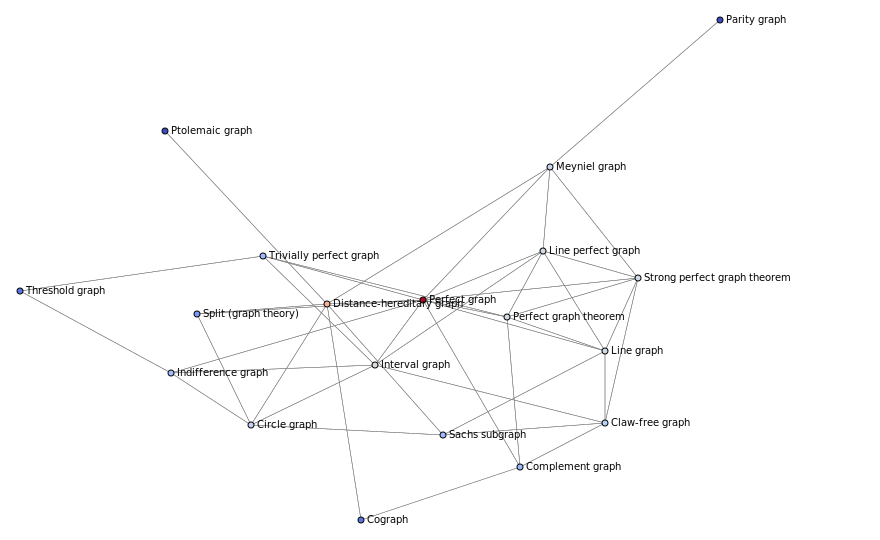

In [20]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [21]:
[print(n) for n in sorted(G_comm.nodes)]

Circle graph
Claw-free graph
Cograph
Complement graph
Distance-hereditary graph
Indifference graph
Interval graph
Line graph
Line perfect graph
Meyniel graph
Parity graph
Perfect graph
Perfect graph theorem
Ptolemaic graph
Sachs subgraph
Split (graph theory)
Strong perfect graph theorem
Threshold graph
Trivially perfect graph


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

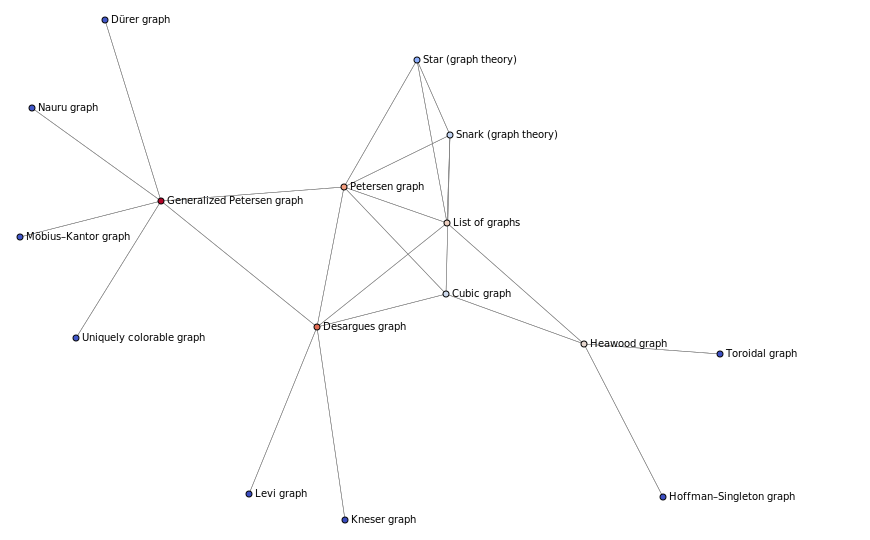

In [22]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [23]:
[print(n) for n in sorted(G_comm.nodes)]

Cartesian product of graphs
Cubic graph
Desargues graph
Dürer graph
Factor graph
Generalized Petersen graph
Heawood graph
Hoffman–Singleton graph
Kneser graph
Levi graph
List of graphs
Möbius–Kantor graph
Nauru graph
Petersen graph
Snark (graph theory)
Star (graph theory)
Toroidal graph
Uniquely colorable graph


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

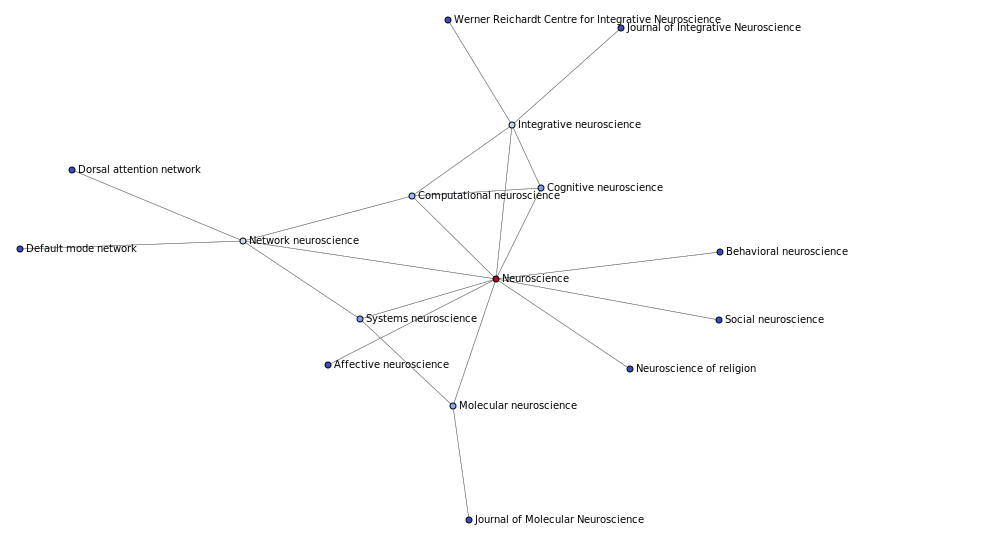

In [24]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [25]:
[print(n) for n in sorted(G_comm.nodes)]

Affective neuroscience
Behavioral neuroscience
Cognitive neuroscience
Computational neuroscience
Default mode network
Dorsal attention network
Integrative neuroscience
Journal of Integrative Neuroscience
Journal of Molecular Neuroscience
Molecular neuroscience
Network neuroscience
Neuroscience
Neuroscience of religion
Social neuroscience
Systems neuroscience
Werner Reichardt Centre for Integrative Neuroscience


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

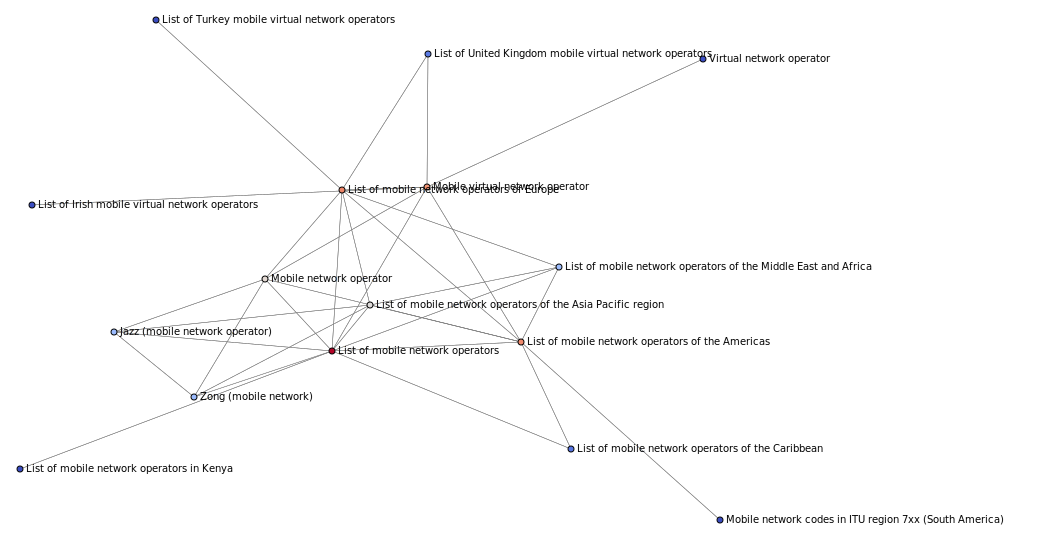

In [26]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [27]:
[print(n) for n in sorted(G_comm.nodes)]

Jazz (mobile network operator)
List of Irish mobile virtual network operators
List of Turkey mobile virtual network operators
List of United Kingdom mobile virtual network operators
List of mobile network operators
List of mobile network operators in Kenya
List of mobile network operators of Europe
List of mobile network operators of the Americas
List of mobile network operators of the Asia Pacific region
List of mobile network operators of the Caribbean
List of mobile network operators of the Middle East and Africa
Mobile network codes in ITU region 7xx (South America)
Mobile network operator
Mobile virtual network operator
Virtual network operator
Zong (mobile network)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

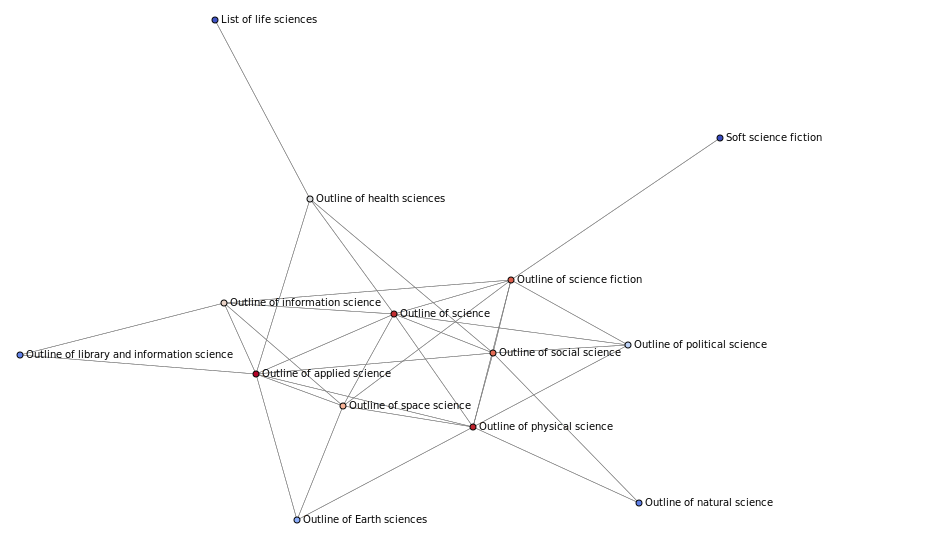

In [28]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [29]:
[print(n) for n in sorted(G_comm.nodes)]

List of life sciences
Outline of Earth sciences
Outline of applied science
Outline of health sciences
Outline of information science
Outline of library and information science
Outline of natural science
Outline of physical science
Outline of political science
Outline of science
Outline of science fiction
Outline of social science
Outline of space science
Soft science fiction


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

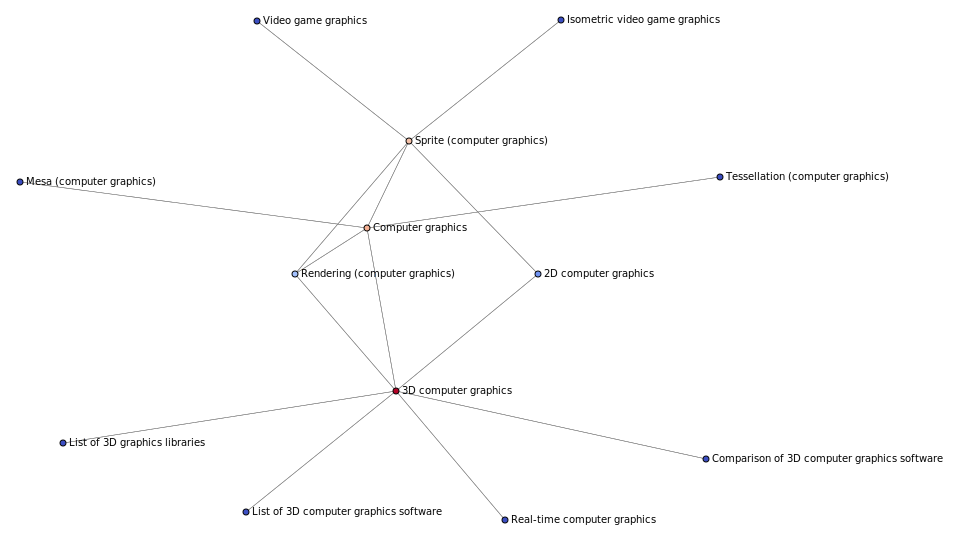

In [30]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [31]:
[print(n) for n in sorted(G_comm.nodes)]

2D computer graphics
3D computer graphics
Comparison of 3D computer graphics software
Computer graphics
Isometric video game graphics
List of 3D computer graphics software
List of 3D graphics libraries
Mesa (computer graphics)
Real-time computer graphics
Rendering (computer graphics)
Sprite (computer graphics)
Tessellation (computer graphics)
Video game graphics


[None, None, None, None, None, None, None, None, None, None, None, None, None]

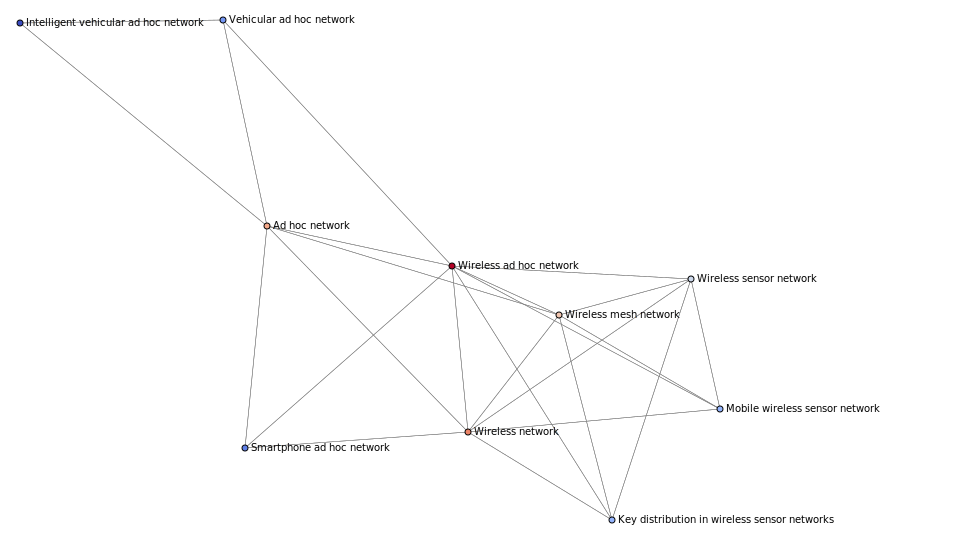

In [32]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [33]:
[print(n) for n in sorted(G_comm.nodes)]

Ad hoc network
Intelligent vehicular ad hoc network
Key distribution in wireless sensor networks
Lists of network protocols
Mobile wireless sensor network
Routing in delay-tolerant networking
Smartphone ad hoc network
Vehicular ad hoc network
Wireless ad hoc network
Wireless mesh network
Wireless network
Wireless sensor network


[None, None, None, None, None, None, None, None, None, None, None, None]

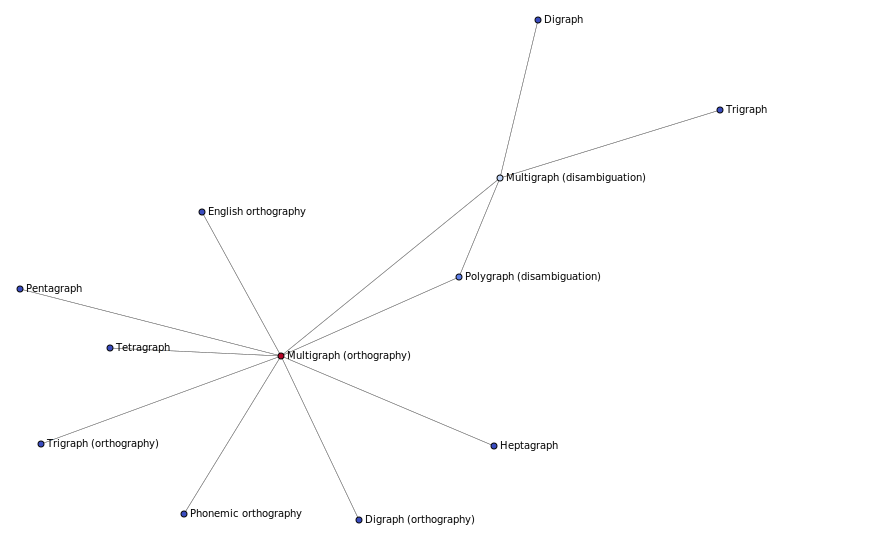

In [34]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [35]:
[print(n) for n in sorted(G_comm.nodes)]

Digraph
Digraph (orthography)
English orthography
Heptagraph
Multigraph (disambiguation)
Multigraph (orthography)
Pentagraph
Phonemic orthography
Polygraph (disambiguation)
Tetragraph
Trigraph
Trigraph (orthography)


[None, None, None, None, None, None, None, None, None, None, None, None]